In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


## Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.89:33195 --name dummy-name --nthreads 36 --memory-limit 93.13GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.89:33195,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load in data

In [6]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds_yearly = xr.open_mfdataset(
        datadir("model/yearly_output_0.25deg/CM4Xp125_historical_transient_tracers.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")

z_l = ds_yearly.zl.values
z_i = np.zeros(len(z_l) + 1)
for i in range(len(z_l)):
    z_i[i + 1] = (2 * (z_l[i] - z_i[i])) + z_i[i]
z_i[-1] += 2

d_i = np.arange(0, 6500, 100)
d_l = ((d_i[1:] - d_i[0:-1]) / 2) + d_i[0:-1]

ds_yearly = approximate_z(ds_yearly, dim = "zl").rename({"z":"depth"})

ds_yearly = ds_yearly.rename({"zl":"z_l"}).assign_coords({"z_i":z_i, 
                                     "depth_i":d_i, 
                                     "depth_l":d_i})

grid = CM4Xutils.ds_to_grid(ds_yearly, Zprefix = "z")
ds_yearly = ds_yearly.chunk({"z_l": -1, "year":1})

In [7]:
cfc11_mass_by_depth = grid.transform((ds_yearly["cfc11"] * ds_yearly["thkcello"]).fillna(0.), 'Z', d_i,
                                   target_data=ds_yearly["depth"], method='conservative')
layer_thickness_by_depth = grid.transform(ds_yearly["thkcello"].fillna(0.), 'Z', d_i,
                                   target_data=ds_yearly["depth"], method='conservative')

cfc11_by_depth = (cfc11_mass_by_depth / layer_thickness_by_depth).where(layer_thickness_by_depth != 0.0)
cfc11_by_depth = xr.merge([cfc11_by_depth.rename("cfc11"), layer_thickness_by_depth])

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as di

In [8]:
cfc11_by_depth = cfc11_by_depth.where(cfc11_by_depth.geolat < -40)
cfc11_by_z = ds_yearly[["cfc11", "thkcello"]].where(ds_yearly.geolat < -40)

In [9]:
def volume_weighted_average(ds):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])
    return weighted_ds

In [10]:
SO_cfc11 = volume_weighted_average(cfc11_by_depth).compute()

/tmp/ipykernel_117209/477466137.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  weighted_ds = (ds.drop(["thkcello"]) * weights).sum(["xh", "yh"]) / weights.sum(["xh", "yh"])


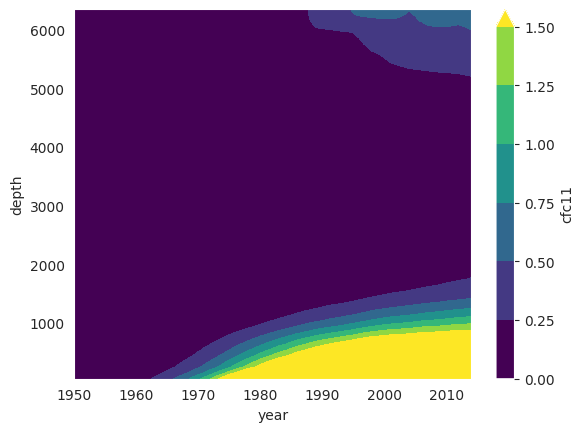

In [11]:
levels = np.arange(0, 1.51, 0.25)

((1e12/1035) * SO_cfc11.cfc11).sel(year = slice(1950, 2014)).T.plot.contourf(levels = levels)